# Senior Income and Home Value Distributions For San Diego County

This package extracts the home value and household income for households in San DIego county with one or more household members aged 65 or older. .  The base data is from the 2015 5 year PUMS sample, from IPUMS<sup>[1](#ipums)</sup>. The primary dataset variables used are: HHINCOME and VALUEH. 


This extract is intended for analysis of senior issues in San Diego County, so the record used are further restricted with these filters: 

* WHERE AGE > = 65
* HHINCOME < 9999999
* VALUEH < 9999999 
* STATEFIP = 6 ( California ) 
* COUNTYFIPS = 73 ( San Diego County ) 

The limits on the HHINCOME and VALUEH variables eliminate top coding. 

This analysis used the IPUMS [(ipums)](#ipums) data


In [1]:
%matplotlib inline
%load_ext metatab

%load_ext autoreload
%autoreload 2

%mt_lib_dir lib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import metatab as mt
import seaborn as sns; sns.set(color_codes=True)
import sqlite3
from IPython.display import display_html, HTML, display

import statsmodels as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy import integrate, stats

from incomedist import * 
from multikde import MultiKde 

plt.rcParams['figure.figsize']=(6,6)

In [2]:
%mt_open_package


In [3]:
!pwd


/Volumes/Storage/proj/virt/data-projects/sdrdl-data-projects/ipums.org/ipums.org-income_homevalue/notebooks


# Source Data

The PUMS data is a sample, so both household and person records have weights. We use those weights to replicate records. We are not adjusting the values for CPI, since we don't have a CPI for 2015, and because the medians for income comes out pretty close to those from the 2015 5Y ACS. 

The `HHINCOME` and `VALUEH` have the typical distributions for income and home values, both of which look like Poisson distributions. 


In [4]:
# Check the weights for the whole file to see if they sum to the number
# of households and people in the county. They don't, but the sum of the weights for households is close, 
# 126,279,060 vs about 116M housholds
con = sqlite3.connect("ipums.sqlite")
wt = pd.read_sql_query("SELECT YEAR, DATANUM, SERIAL, HHWT, PERNUM, PERWT FROM ipums "
                       "WHERE PERNUM = 1 AND YEAR = 2015", con)

wt.drop(0, inplace=True)

nd_s = wt.drop_duplicates(['YEAR', 'DATANUM','SERIAL'])
country_hhwt_sum = nd_s[nd_s.PERNUM == 1]['HHWT'].sum()

len(wt), len(nd_s), country_hhwt_sum

(1375480, 1375480, 126279060.0)

In [5]:
import sqlite3

# PERNUM = 1 ensures only record for each household 

con = sqlite3.connect("ipums.sqlite")
senior_hh = pd.read_sql_query(
                       "SELECT DISTINCT SERIAL, HHWT, PERWT, HHINCOME, VALUEH "
                       "FROM ipums "
                       "WHERE "
                      # "AGE >= 65 AND " 
                       "HHINCOME < 9999999 AND VALUEH < 9999999 AND "
                       "STATEFIP = 6 AND COUNTYFIPS=73 ", con)

In [6]:
# Since we're doing a probabilistic simulation, the easiest way to deal with the weight is just to repeat rows. 
# However, adding the weights doesn't change the statistics much, so they are turned off now, for speed. 

def generate_data():
    
    for index, row in senior_hh.drop_duplicates('SERIAL').iterrows():
        #for i in range(row.HHWT):
        yield (row.HHINCOME, row.VALUEH)
  
incv = pd.DataFrame(list(generate_data()), columns=['HHINCOME', 'VALUEH'])

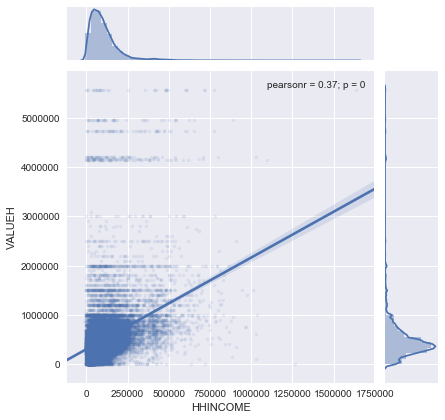

In [7]:

sns.jointplot(x="HHINCOME", y="VALUEH", marker='.', scatter_kws={'alpha': 0.1}, data=incv, kind='reg');

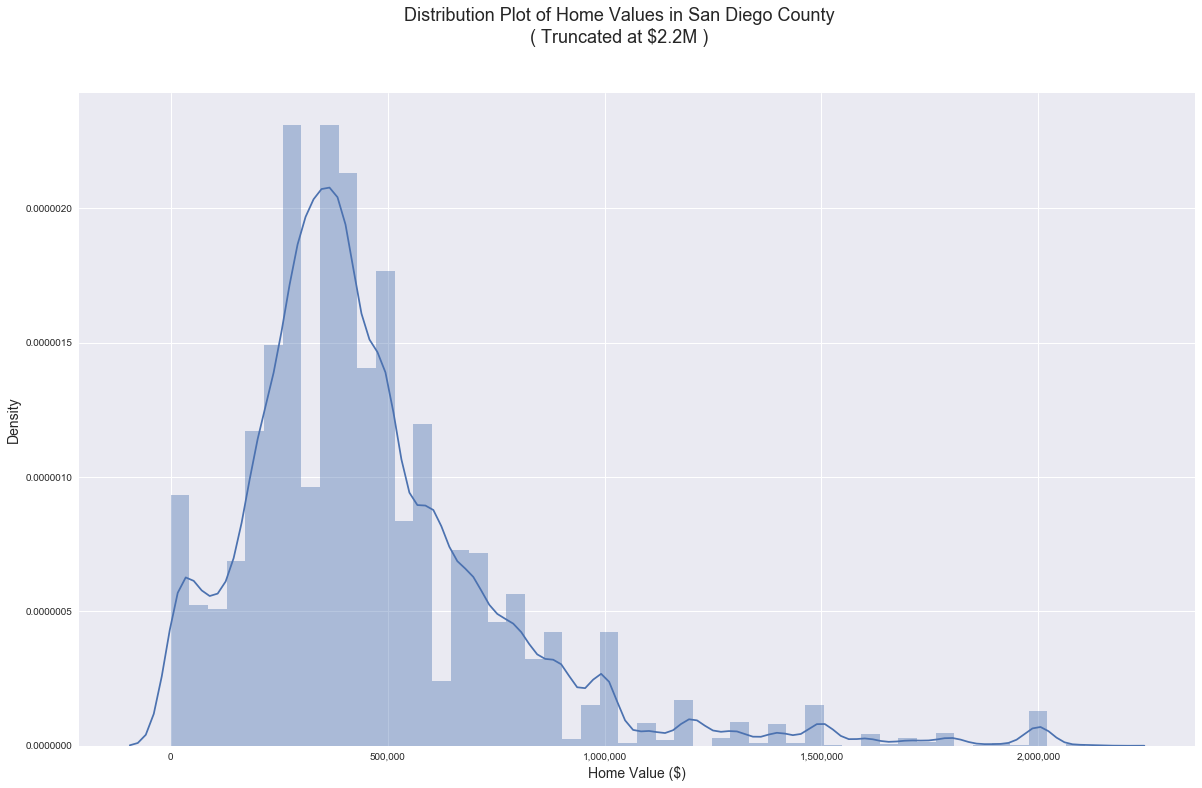

In [8]:
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
    

fig.suptitle("Distribution Plot of Home Values in San Diego County\n"
             "( Truncated at $2.2M )", fontsize=18)
sns.distplot(incv.VALUEH[incv.VALUEH <2200000], ax=ax);
ax.set_xlabel('Home Value ($)', fontsize=14)
ax.set_ylabel('Density', fontsize=14);
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


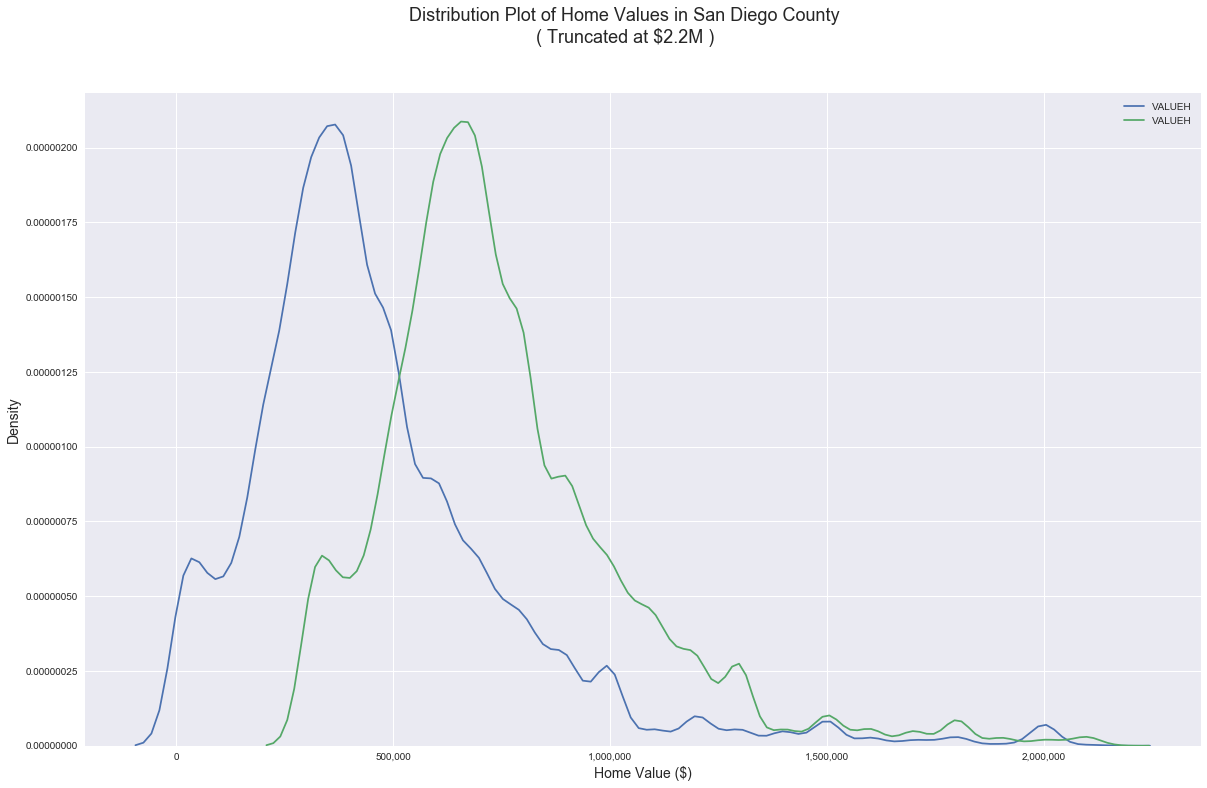

In [31]:
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
    

fig.suptitle("Distribution Plot of Home Values in San Diego County\n"
             "( Truncated at $2.2M )", fontsize=18)
sns.kdeplot(incv.VALUEH[incv.VALUEH <2200000], ax=ax);
sns.kdeplot(incv.VALUEH[incv.VALUEH <1900000]+300000, ax=ax);
ax.set_xlabel('Home Value ($)', fontsize=14)
ax.set_ylabel('Density', fontsize=14);
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Procedure

After extracting the data for HHINCOME and VALUEH, we rank both values and then quantize the rankings into 10 groups, 0 through 9, `hhincome_group` and `valueh_group`. The `HHINCOME` variable correlates with `VALUEH` at .36, and the quantized rankings `hhincome_group` and `valueh_group` correlate at .38.

Initial attempts were made to fit curves to the income and home value distributions, but it is very difficult to find well defined models that fit real income distributions. Bordley [(bordley)](#bordley) analyzes the fit for 15 different distributions, reporting success with variations of the generalized beta distribution, gamma and Weibull. Majumder [(majumder)](#majumder) proposes a four parameter model with variations for special cases. None of these models were considered well established enough to fit within the time contraints for the project, so this analysis will use empirical distributions that can be scale to fit alternate parameters. 


In [9]:

incv['valueh_rank'] = incv.rank()['VALUEH']
incv['valueh_group'] = pd.qcut(incv.valueh_rank, 10, labels=False )
incv['hhincome_rank'] = incv.rank()['HHINCOME']
incv['hhincome_group'] = pd.qcut(incv.hhincome_rank, 10, labels=False )
incv[['HHINCOME', 'VALUEH', 'hhincome_group', 'valueh_group']] .corr()

,HHINCOME,VALUEH,hhincome_group,valueh_group
HHINCOME,1.000000,0.366223,0.802594,0.408835
VALUEH,0.366223,1.000000,0.281755,0.662486
hhincome_group,0.802594,0.281755,1.000000,0.415761
valueh_group,0.408835,0.662486,0.415761,1.000000


In [10]:
from metatab.pands import MetatabDataFrame
odf = MetatabDataFrame(incv)
odf.name = 'income_homeval'
odf.title = 'Income and Home Value Records for San Diego County'
odf.HHINCOME.description = 'Household income'
odf.VALUEH.description = 'Home value'
odf.valueh_rank.description = 'Rank of the VALUEH value'
odf.valueh_group.description = 'The valueh_rank value quantized into 10 bins, from 0 to 9'
odf.hhincome_rank.description = 'Rank of the HHINCOME value'
odf.hhincome_group.description = 'The hhincome_rank value quantized into 10 bins, from 0 to 9'

%mt_add_dataframe odf  --materialize

Then, we group the dataset by `valueh_group` and collect all of the income values for each group. These groups have different distributions, with the lower numbered group shewing to the left and the higher numbered group skewing to the right. 

To use these groups in a simulation, the user would select a group for a subject's home value, then randomly select an income in that group. When this is done many times, the original `VALUEH` correlates to the new distribution ( here, as `t_income` ) at .33, reasonably similar to the original correlations. 

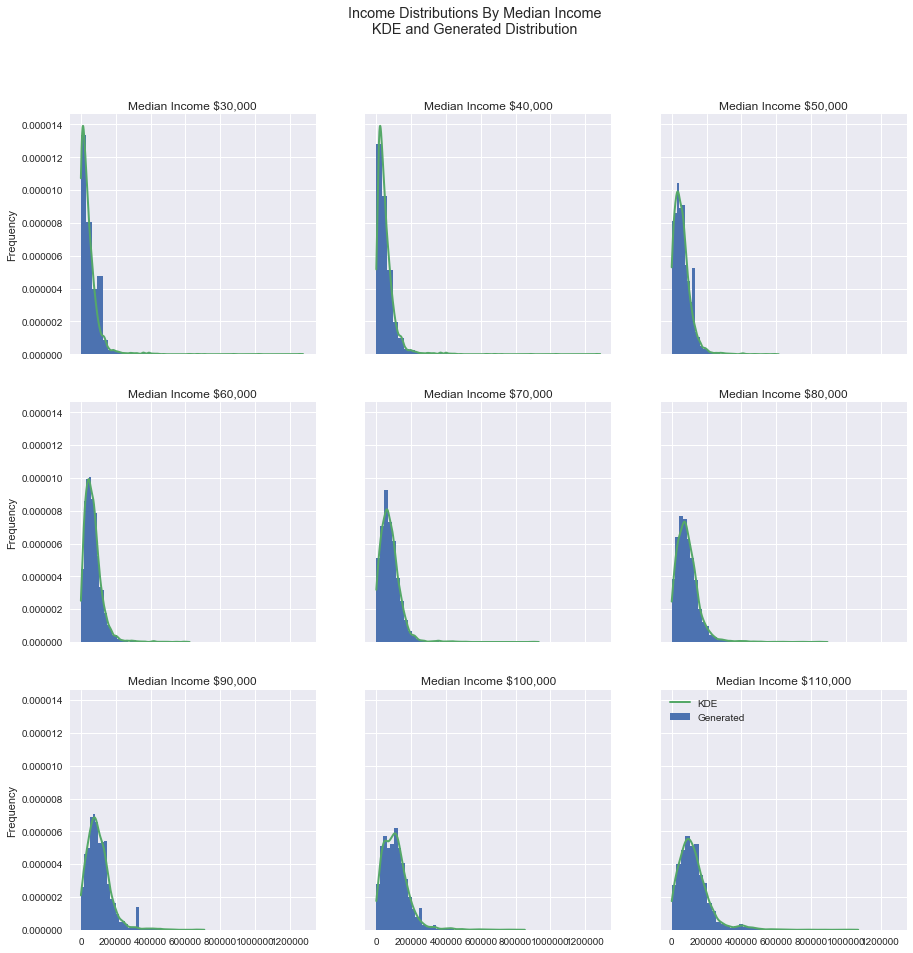

In [24]:
import matplotlib.pyplot as plt
import numpy as np

mk = MultiKde(odf, 'valueh_group', 'HHINCOME')

fig,AX = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))

incomes = [30000,
          40000,
          50000,
          60000,
          70000,
          80000,
          90000,
          100000,
          110000]

for mi, ax in zip(incomes, AX.flatten()):
    s, d, icdf, g = mk.make_kde(mi)
    syn_d = mk.syn_dist(mi, 10000)
   
    syn_d.plot.hist(ax=ax, bins=40, title='Median Income ${:0,.0f}'.format(mi), normed=True, label='Generated')

    ax.plot(s,d, lw=2, label='KDE')
    
fig.suptitle('Income Distributions By Median Income\nKDE and Generated Distribution')
plt.legend(loc='upper left')
plt.show()

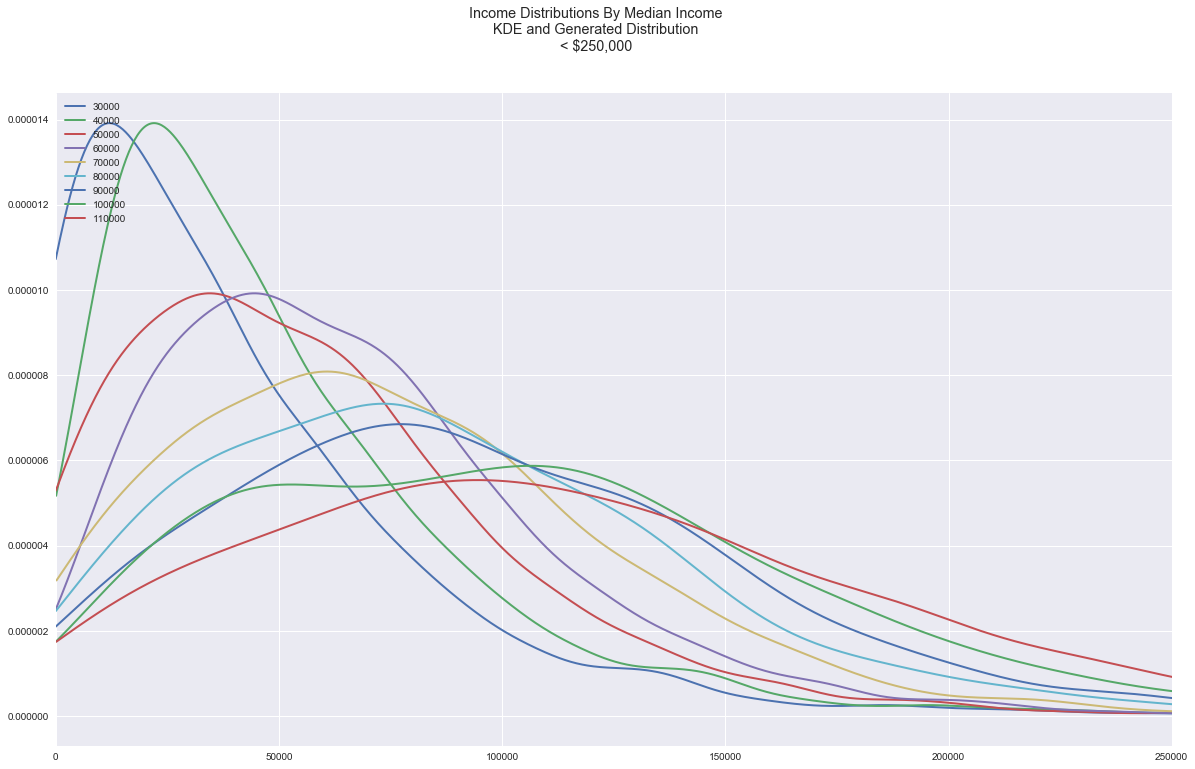

In [43]:
import matplotlib.pyplot as plt
import numpy as np

mk = MultiKde(odf, 'valueh_group', 'HHINCOME')

fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)

incomes = [30000,
          40000,
          50000,
          60000,
          70000,
          80000,
          90000,
          100000,
          110000]

for mi in incomes:
    s, d, icdf, g = mk.make_kde(mi)
    syn_d = mk.syn_dist(mi, 10000)

    #syn_d.plot.hist(ax=ax, bins=40,  normed=True, label='Generated')

    ax.plot(s,d, lw=2, label=str(mi))
    
fig.suptitle('Income Distributions By Median Income\nKDE and Generated Distribution\n< $250,000')
plt.legend(loc='upper left')
ax.set_xlim([0,250000])
plt.show()

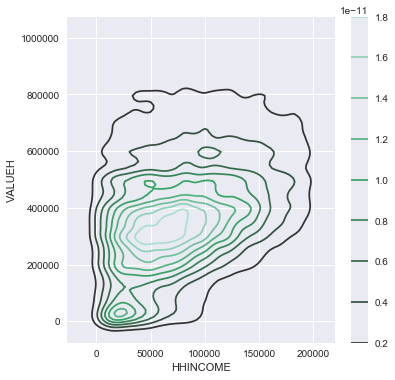

In [27]:
df_kde = incv[ (incv.HHINCOME <200000) & (incv.VALUEH < 1000000) ]
ax = sns.kdeplot(df_kde.HHINCOME, df_kde.VALUEH, cbar=True)

A scatter matrix show similar structure for `VALUEH` and `t_income`.

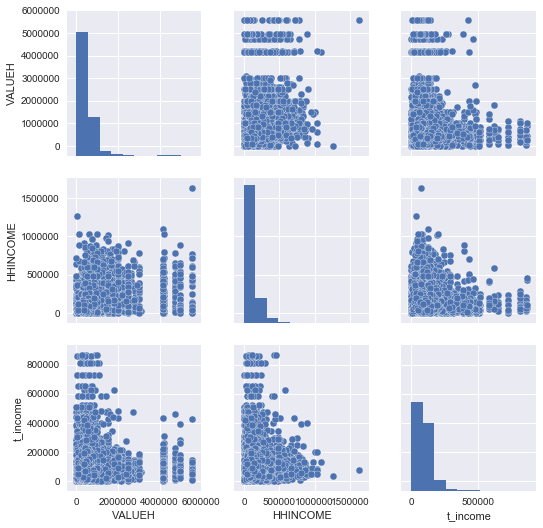

In [12]:
t = incv.copy()
t['t_income'] = mk.syn_dist(t.HHINCOME.median(), len(t))
t[['HHINCOME','VALUEH','t_income']].corr()

sns.pairplot(t[['VALUEH','HHINCOME','t_income']]);

The simulated incomes also have similar statistics to the original incomes. However, the median income is high. In San Diego county, the median household income for householders 65 and older in the 2015 5 year ACS about \$51K, versus \$56K here. For home values, the mean home value for 65+ old homeowners is \$468K in the 5 year ACS, vs \$510K here. 

In [13]:

display(HTML("<h3>Descriptive Stats</h3>"))
t[['VALUEH','HHINCOME','t_income']].describe()

,VALUEH,HHINCOME,t_income
count,3.398900e+04,3.398900e+04,33989.000000
mean,5.026555e+05,1.078240e+05,94730.441494
std,4.992779e+05,9.825681e+04,67298.777055
min,0.000000e+00,-7.500000e+03,70.851880
25%,2.800000e+05,4.590000e+04,49300.000000
50%,4.000000e+05,8.430000e+04,84230.084421
75%,6.000000e+05,1.371500e+05,124300.000000
max,5.567000e+06,1.636000e+06,864200.000000


In [14]:
display(HTML("<h3>Correlations</h3>"))
t[['VALUEH','HHINCOME','t_income']].corr()

,VALUEH,HHINCOME,t_income
VALUEH,1.000000,0.366223,0.005063
HHINCOME,0.366223,1.000000,0.004573
t_income,0.005063,0.004573,1.000000


# Bibliography

In [15]:
%mt_bibliography

<IPython.core.display.Latex object>

In [16]:
# Tests

Create a new KDE distribution, based on the home values, including only home values ( actually KDE supports ) between $130,000 and $1.5M. 

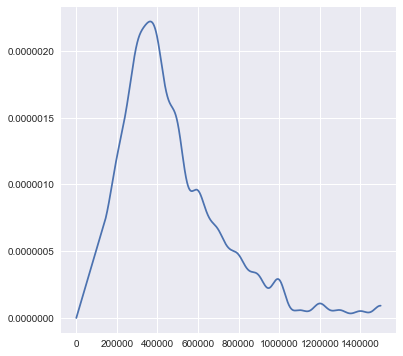

In [17]:
s,d = make_prototype(incv.VALUEH.astype(float), 130_000, 1_500_000)

plt.plot(s,d)

Overlay the prior plot with the histogram of the original values. We're using np.histogram to make the histograph, so it appears as a line chart. 

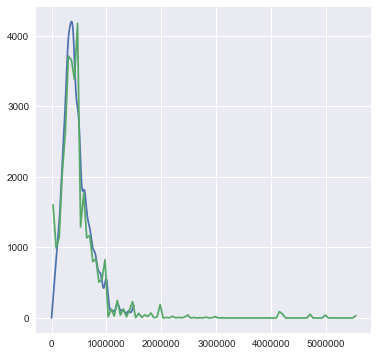

In [18]:
v = incv.VALUEH.astype(float).sort_values()
#v = v[ ( v > 60000 ) & ( v < 1500000 )]

hist, bin_edges = np.histogram(v, bins=100, density=True)

bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

bin_width = bin_middles[1] - bin_middles[0]

assert np.isclose(sum(hist*bin_width),1) # == 1 b/c density==True

hist, bin_edges = np.histogram(v, bins=100) # Now, without 'density'

# And, get back to the counts, but now on the KDE

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(s,d * sum(hist*bin_width));

ax.plot(bin_middles, hist);


Show an a home value curve, interpolated to the same values as the distribution. The two curves should be co-incident. 

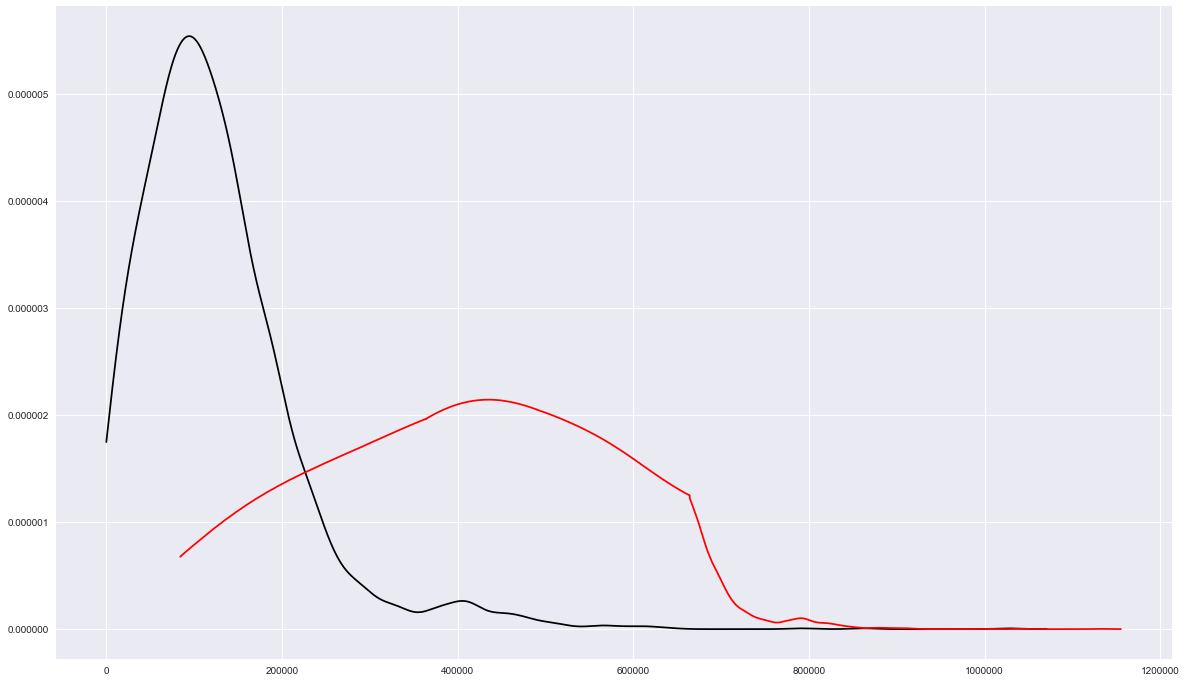

In [45]:
def plot_compare_curves(p25, p50, p75):
    fig = plt.figure(figsize = (20,12))
    ax = fig.add_subplot(111)

    sp, dp = interpolate_curve(s, d, p25, p50, p75)

    ax.plot(pd.Series(s), d, color='black');
    ax.plot(pd.Series(sp), dp, color='red');

# Re-input the quantiles for the KDE
# Curves should be co-incident
plot_compare_curves(2.800000e+05,4.060000e+05,5.800000e+05)


Now, interpolate to the values for the county, which shifts the curve right. 

In [ ]:
# Values for SD County home values
plot_compare_curves(349100.0,485900.0,703200.0)


Here is an example of creating an interpolated distribution, then generating a synthetic distribution from it. 

In [ ]:
sp, dp = interpolate_curve(s, d, 349100.0,485900.0,703200.0)
v = syn_dist(sp, dp, 10000)

plt.hist(v, bins=100);  
pd.Series(v).describe()